### Simple wave reflection model
#### Based on Brad Story's dissertation (1995)

In [245]:
using Plots
using WAV
using CSV
using DataFrames
include("../utils.jl")

find_peaks (generic function with 1 method)

In [246]:
# Parameters
fs = 44100 # Sampling frequency
dur = 0.3 # Duration in seconds
samples = Int(fs * dur) # Total number of samples

R = 128/(9*π^2)
bprev = 0.0
fprev = 0.0
prev_pressure = 0.0

# A = [3, 2, 1, 1, 2, 3] # Areas

# L = repeat([0.396825], length(A)) # Lengths
# sections = length(A)
# F = repeat([0.0], sections)
# B = repeat([0.0], sections)
# ρ = 0.00114 # units? g/cm^3
# c = 35000 # units? cm/s
# generic_loss = 0.99999 # Generic loss factor

output_pressure = []

Any[]

In [247]:
# These are already reversed from Fant's
# so these are cross-sectional area as a function of distance from glottis

df = CSV.read("../matlab/fant_area_functions.txt", DataFrame, delim=',', header=false)

iy = tl_vocal_tract(Vector(df[1, :]), 0.375, "iy")
ei = tl_vocal_tract(Vector(df[2, :]), 0.375, "ei")
ah = tl_vocal_tract(Vector(df[3, :]), 0.3864, "ah")
oa = tl_vocal_tract(Vector(df[4, :]), 0.4205, "oa")
uu = tl_vocal_tract(Vector(df[5, :]), 0.4432, "uu")

A = ah.a

sections = length(A)
println("Sections: $sections")
F = repeat([0.0], sections)
B = repeat([0.0], sections)
ρ = 0.00114 #  g/cm^3 density of air
c = 35000 #  cm/s speend of sound in air
generic_loss = 0.999 # Generic loss factor

Sections: 44


0.999

In [248]:
gp = []
for x in 1:samples
    a = 3
    tmi = 15000
    gwi = 3000
    y = a * exp(-((x-tmi)^2/(2*gwi)^2))
    push!(gp, y)
end

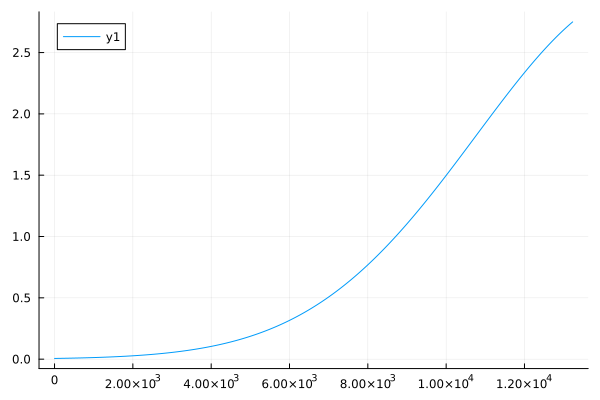

In [249]:
plot(gp)

In [250]:
# src = wavread("./source.wav")[1]

In [251]:
# plot(src)

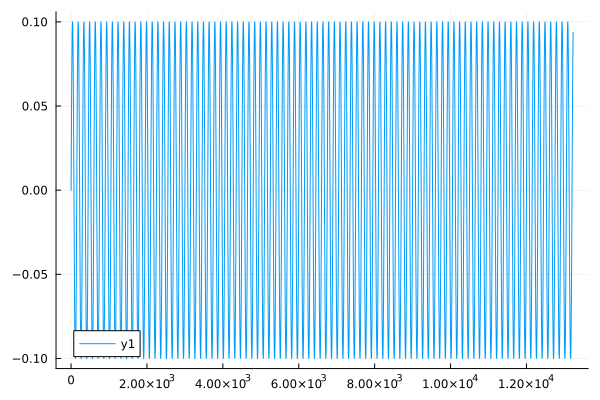

In [252]:
# M = 1 # mass in grams
# R = 35 # resistance in dyn s/cm
# K = 30000 # stiffness dyn/cm
# delta_t = 0.0001 # sampling interval in s
# dur = 1 # duration in seconds
# x1 = 0.1 # deflection of first sample in cm
# x2 = 0.1 # deflection of second sample in cm

# # preliminary calculations
# 
# Int64(dur / delta_t) # total number of samples
# # Generate a sine wave that repeats every 20 samples with amplitude 0.1
period = 150
amplitude = 0.1
sine_wave = [amplitude * sin(2 * pi * (i-1) / period) for i in 1:samples]
# # plot(sine_wave, title="Sine wave: period=20, amplitude=0.1")
# F = zeros(samps) # force applied at each sample
# # F = sine_wave # force applied at each sample
# x = zeros(samps) # displacement at each sample
# # x = sine_wave # displacement at each sample
# x[1] = x1
# x[2] = x2

# # Gets the next displacement of the mass given previous displacement and other variables

# function get_next_displacement(n, M, R, K, delta_t)
#     return (2 - ((delta_t*R)/M) -(((delta_t^2)*K)/M))*x[n] + (((delta_t*R)/M)-1)*x[n-1] + ((delta_t^2)/M)*F[n]
# end

# for n in 2:samps-1
#     x[n+1] = get_next_displacement(n, M, R, K, delta_t)
# end

plot(sine_wave[1:end])

In [253]:
sig = sine_wave
samples = length(sig)

13230

In [254]:
inp = rand(samples).*1
# inp = zeros(samples)
# inp[200] = 100
for samp in 1:samples
    # F[1] = sig[samp]

    # println("SAMPLE ", samp)
    # println("--------------------")
    # println("EVENS")

    F[1] = B[1] * generic_loss + inp[samp] * ((ρ * c) / A[1])

    # EVEN JUNCTIONS
    for i in 1:2:sections-2
        i1 = i + 1
        i2 = i + 2
        # println("junction ", i1, "-", i2, " ($i1)")
        Z = ρ * c / A[i] # Acoustic Impedance
        D = A[i1] + A[i2]
        R1 = (A[i1] - A[i2]) / D # Reflection coefficients
        R2 = -R1
        Ψ = F[i1] * R1 + B[i2] * R2
        B[i1] = (B[i2] + Ψ) * generic_loss
        F[i2] = (F[i1] + Ψ) * generic_loss
        # println("Forward Pressures: ", F)
        # println("Backward Pressures: ", B)
    end
    # println("ODDS")
    # ODD JUNCTIONS
    for i in 1:2:sections
        i1 = i
        i2 = i + 1
        # println("junction ", i1, "-", i2, " ($i1)")
        Z = ρ * c / A[i] # Acoustic Impedance
        D = A[i1] + A[i2]
        R1 = (A[i1] - A[i2]) / D # Reflection coefficients
        R2 = -R1
        Ψ = F[i1] * R1 + B[i2] * R2
        B[i1] = (B[i2] + Ψ) * generic_loss
        F[i2] = (F[i1] + Ψ) * generic_loss
            
    end
    # B[end] = -F[end]
    a = sqrt(A[end]/π)
    L = (2/(1/fs))*8*a/(3*π*c)
    a2 = -R-L+R*L
    a1 = -R+L-R*L
    b2 = R+L+R*L
    b1 = -R+L+R*L
    B[end] = (1/b2)*(F[end]*a2+fprev*a1+bprev*b1)
    pout = (1/b2)*(prev_pressure*b1+F[end]*(b2+a2)+fprev*(a1-b1))
    prev_pressure = pout
    bprev = B[end]
    fprev = F[end]
    push!(output_pressure, pout)
end

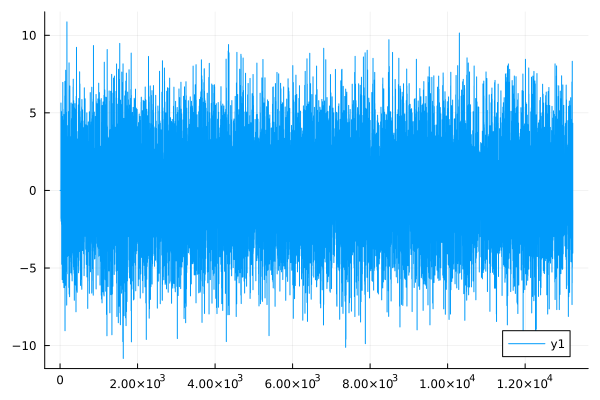

In [255]:
# println("Output Pressure: ", output_pressure)
plot(output_pressure[1:end])

In [256]:
wavwrite(Float64.(sig), fs, "input.wav")
wavwrite(Float64.(output_pressure), fs, "output.wav")

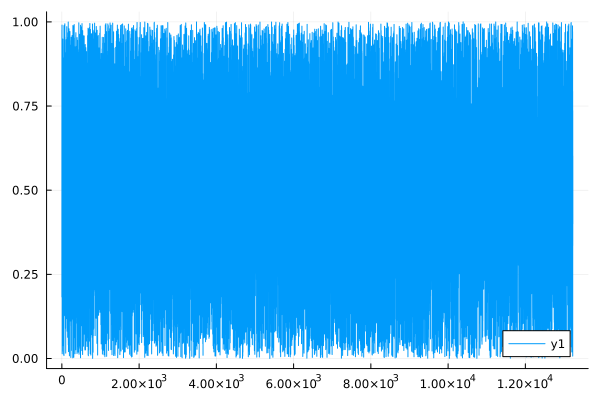

In [257]:
plot(inp)